In [ ]:
import matplotlib.pyplot as plt

from astropy.time import Time
from astropy.visualization import quantity_support, time_support

from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.time import parse_time
from sunpy.time import TimeRange
from sunpy.timeseries import TimeSeries

In [ ]:
time_event_start = Time('2024-03-23 00:00:00')
time_event_end   = Time('2024-03-23 04:00:00')
tr = a.Time(time_event_start, time_event_end)
time_range = TimeRange(time_event_start, b=time_event_end)

In [ ]:
q_goes = a.Instrument.xrs & a.goes.SatelliteNumber(18) & a.Resolution('flx1s')
q_hek = a.hek.EventType('FL') & (a.hek.FRM.Name == 'SWPC')

In [ ]:
q_flare = Fido.search(tr, q_goes | q_hek)

In [ ]:
q_flare

<sunpy.net.fido_factory.UnifiedResponse object>
Results from 2 Providers:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2024-03-23 00:00:00.000 2024-03-23 23:59:59.999 ...     NOAA      flx1s

2 Results from the HEKClient:

gs_thumburl ...
----------- ...
            ...
            ...

In [ ]:
file_goes = Fido.fetch(q_flare[0], path='data/{instrument}/{file}')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [ ]:
ts_goes = TimeSeries(file_goes[0], concatenate=True)

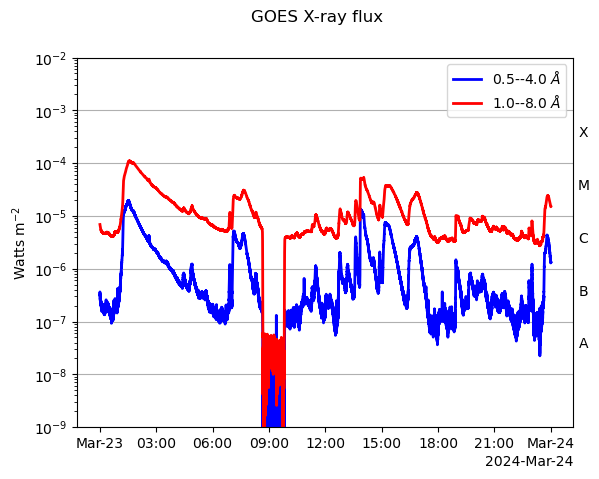

In [ ]:
ts_goes.peek()

In [ ]:
ts_goes_flare = ts_goes.truncate(time_range)

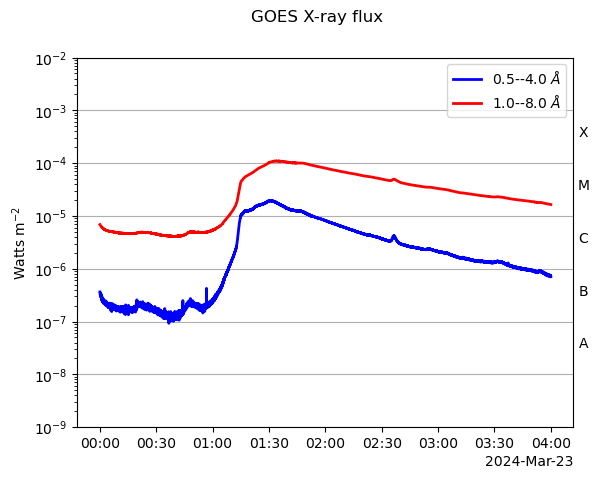

In [ ]:
ts_goes_flare.peek()

In [ ]:
hek_results = q_flare['hek']
flares_hek = hek_results[1]

In [ ]:
print(flares_hek['event_starttime'])
print(flares_hek['event_peaktime'])
print(flares_hek['event_endtime'])
print(flares_hek['fl_goescls'])

2024-03-23 00:58:00.000
2024-03-23 01:33:00.000
2024-03-23 02:21:00.000
X1.1


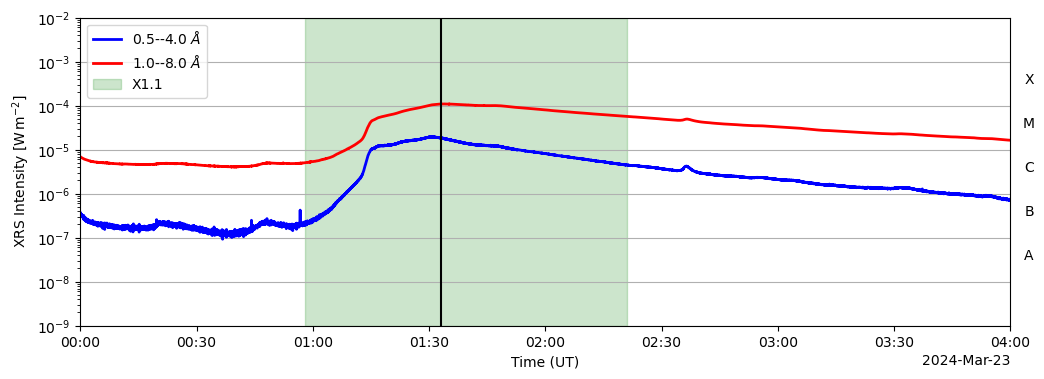

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
ts_goes_flare.plot(axes=ax)
ax.axvline(parse_time(flares_hek['event_peaktime']).datetime, color='black')
ax.axvspan(
    parse_time(flares_hek['event_starttime']).datetime,
    parse_time(flares_hek['event_endtime']).datetime,
    alpha=0.2, color='green',
    label=flares_hek['fl_goescls']
)
ax.legend(loc=2)
ax.set_yscale('log')
ax.set_xlim(tr.start.to_datetime(), tr.end.to_datetime())
ax.set_ylabel(f'XRS Intensity [{ts_goes_flare.units["xrsb"]:latex_inline}]')
ax.set_xlabel('Time (UT)')
plt.show()

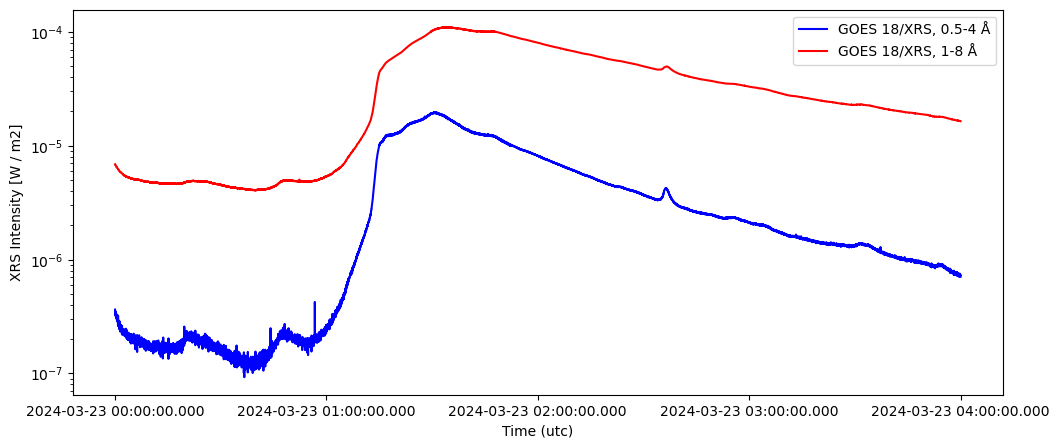

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
with quantity_support():
    with time_support(simplify=True):
        ax.plot(ts_goes_flare.time, ts_goes_flare.quantity('xrsa'), color='blue', label='GOES 18/XRS, 0.5-4 Å')
        ax.plot(ts_goes_flare.time, ts_goes_flare.quantity('xrsb'), color='red', label='GOES 18/XRS, 1-8 Å')
ax.set_yscale('log')
ax.set_ylabel(f'XRS Intensity [{ts_goes_flare.units["xrsb"]}]')
ax.legend()
plt.show()

In [ ]:
time_peak = ts_goes_flare.time[ts_goes_flare.quantity('xrsb').argmax()]

In [ ]:
time_peak

<Time object: scale='utc' format='iso' value=2024-03-23 01:33:42.702>

In [ ]:
from stixpy.net.client import STIXClient

In [ ]:
a.stix.DataProduct

Attribute Name,Client,Full Name,Description
aux_ephemeris,STIX,aux_ephemeris,Auxiliary ephemeris data
cal_energy,STIX,cal_energy,Energy Calibration
hk_maxi,STIX,hk_maxi,House Keeping Maxi Report
ql_background,STIX,ql_background,Quick look background light curve
ql_calibration_spectrum,STIX,ql_calibration_spectrum,Quick look energy calibration spectrum
ql_flareflag,STIX,ql_flareflag,Quick look flare flag including location
ql_lightcurve,STIX,ql_lightcurve,Quick look light curve
ql_spectra,STIX,ql_spectra,Quick look spectra
ql_tmstatusflarelist,STIX,ql_tmstatusflarelist,Quick look TM Status and flare list
ql_variance,STIX,ql_variance,Quick look variance curve


In [ ]:
q_stix = a.Instrument.stix & a.stix.DataProduct.ql_lightcurve

In [ ]:
res_stix = Fido.search(tr, q_stix)

In [ ]:
res_stix

Start Time,End Time,Instrument,Level,DataType,DataProduct,Ver,Request ID
Time,Time,str4,str2,str2,str13,str3,str1
2024-03-23 00:00:00.000,2024-03-23 23:59:59.999,STIX,L1,QL,ql-lightcurve,V02,-


In [ ]:
file_stix = Fido.fetch(res_stix, path='data/{instrument}/{file}')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [ ]:
from stixpy.timeseries import quicklook

In [ ]:
ts_stix = TimeSeries('data/STIX', concatenate=True)

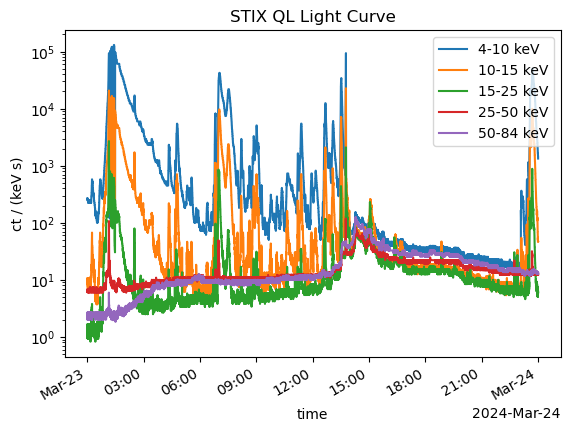

In [ ]:
ts_stix.peek()

In [ ]:
ts_stix_flare = ts_stix.truncate(time_range)

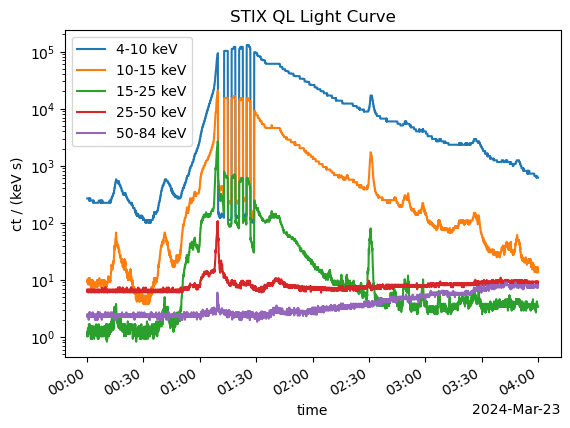

In [ ]:
ts_stix_flare.peek()

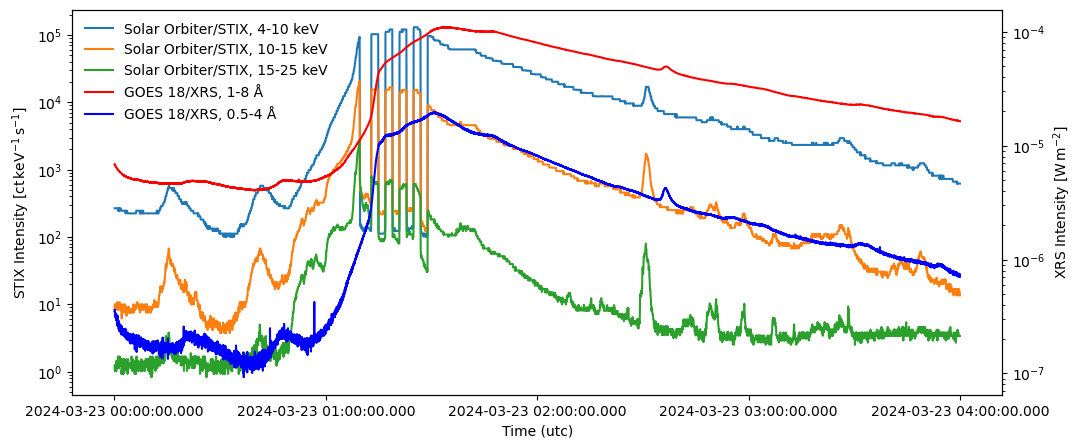

In [ ]:
fig = plt.figure(figsize=(12,5))
ax_stix = fig.add_subplot()
ax_stix.set_ylabel(f'STIX Intensity [{ts_stix_flare.units["4-10 keV"]:latex_inline}]')
ax_goes = ax_stix.twinx()
ax_goes.set_ylabel(f'XRS Intensity [{ts_goes_flare.units["xrsb"]:latex_inline}]')
with time_support(simplify=True):
    l1, = ax_stix.plot(ts_stix_flare.time, ts_stix_flare.quantity('4-10 keV'), color='C0', label='Solar Orbiter/STIX, 4-10 keV')
    l2, = ax_stix.plot(ts_stix_flare.time, ts_stix_flare.quantity('10-15 keV'), color='C1', label='Solar Orbiter/STIX, 10-15 keV')
    l3, = ax_stix.plot(ts_stix_flare.time, ts_stix_flare.quantity('15-25 keV'), color='C2', label='Solar Orbiter/STIX, 15-25 keV')
    l4, = ax_goes.plot(ts_goes_flare.time, ts_goes_flare.quantity('xrsb'), color='red', label='GOES 18/XRS, 1-8 Å')
    l5, = ax_goes.plot(ts_goes_flare.time, ts_goes_flare.quantity('xrsa'), color='blue', label='GOES 18/XRS, 0.5-4 Å')
ax_stix.set_yscale('log')
ax_goes.set_yscale('log')
ax_stix.legend([l1,l2,l3,l4,l5], [l.get_label() for l in [l1,l2,l3,l4,l5]], loc=2, frameon=False)
fig.savefig('flare_lightcurve.png', dpi=300)
plt.show()

In [ ]:
import astropy.time
import astropy.constants as const
from sunpy.coordinates import get_horizons_coord, get_earth

In [ ]:
time = astropy.time.Time('2024-03-23 01:00:00')
earth_loc = get_earth(time_event_start)
solo_loc = get_horizons_coord('SolO', time=time_event_start)
light_travel_time = ((earth_loc.radius - solo_loc.radius) / const.c).to('s')
print(earth_loc.radius)
print(solo_loc.radius)
print(light_travel_time)

2025-01-14 21:26:28 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144)


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144) [sunpy.coordinates.ephemeris]
0.9966575280591737 AU
0.39393178518644917 AU
300.76302903469076 s


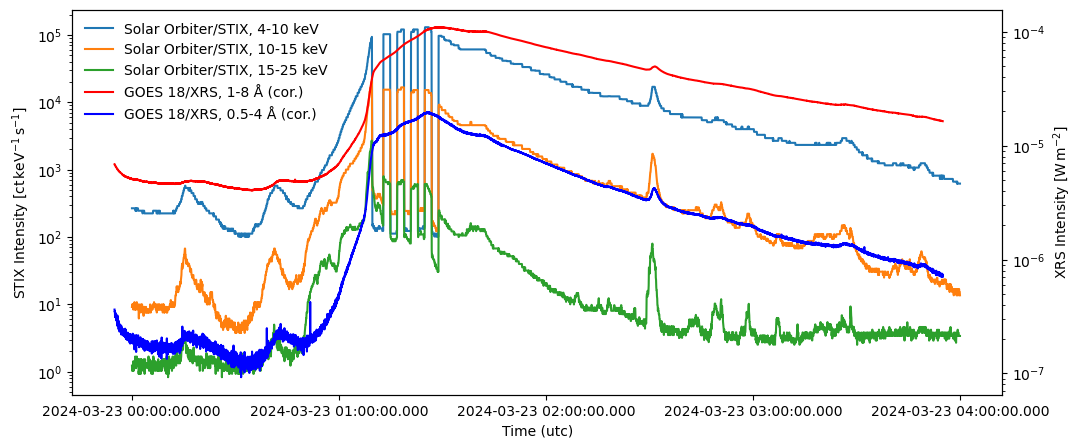

In [ ]:
fig = plt.figure(figsize=(12,5))
ax_stix = fig.add_subplot()
ax_stix.set_ylabel(f'STIX Intensity [{ts_stix_flare.units["4-10 keV"]:latex_inline}]')
ax_goes = ax_stix.twinx()
ax_goes.set_ylabel(f'XRS Intensity [{ts_goes_flare.units["xrsb"]:latex_inline}]')
with time_support(simplify=True):
    l1, = ax_stix.plot(ts_stix_flare.time, ts_stix_flare.quantity('4-10 keV'), color='C0', label='Solar Orbiter/STIX, 4-10 keV')
    l2, = ax_stix.plot(ts_stix_flare.time, ts_stix_flare.quantity('10-15 keV'), color='C1', label='Solar Orbiter/STIX, 10-15 keV')
    l3, = ax_stix.plot(ts_stix_flare.time, ts_stix_flare.quantity('15-25 keV'), color='C2', label='Solar Orbiter/STIX, 15-25 keV')
    l4, = ax_goes.plot(ts_goes_flare.time-light_travel_time, ts_goes_flare.quantity('xrsb'), color='red', label='GOES 18/XRS, 1-8 Å (cor.)')
    l5, = ax_goes.plot(ts_goes_flare.time-light_travel_time, ts_goes_flare.quantity('xrsa'), color='blue', label='GOES 18/XRS, 0.5-4 Å (cor.)')
ax_stix.set_yscale('log')
ax_goes.set_yscale('log')
ax_stix.legend([l1,l2,l3,l4,l5], [l.get_label() for l in [l1,l2,l3,l4,l5]], loc=2, frameon=False)
fig.savefig('flare_lightcurve_corrected.png', dpi=300)
plt.show()